In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import time
%load_ext autoreload
%autoreload 2


In [2]:
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 37 * 37, 512)
        self.fc2 = nn.Linear(512, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        
        x = x.contiguous().view(-1, 32 * 37* 37) # 展平操作
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
import torchvision.transforms as transforms
import os
from PIL import Image
class GlassesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, subdir in enumerate(['pos', 'neg']):
            subdir_path = os.path.join(root_dir, subdir)
            for fname in os.listdir(subdir_path):
                if fname.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(subdir_path, fname))
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image, label
    
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

Epoch 1/10 - Train loss: 0.5298, Train acc: 0.9100 - Val loss: 0.2489, Val acc: 0.8954
Epoch 2/10 - Train loss: 0.1641, Train acc: 0.9550 - Val loss: 0.1347, Val acc: 0.9362
Epoch 3/10 - Train loss: 0.0710, Train acc: 0.9875 - Val loss: 0.0706, Val acc: 0.9732
Epoch 4/10 - Train loss: 0.0501, Train acc: 0.9923 - Val loss: 0.0531, Val acc: 0.9821
Epoch 5/10 - Train loss: 0.0370, Train acc: 0.9962 - Val loss: 0.0488, Val acc: 0.9834
Epoch 6/10 - Train loss: 0.0239, Train acc: 0.9981 - Val loss: 0.0487, Val acc: 0.9821
Epoch 7/10 - Train loss: 0.0175, Train acc: 1.0000 - Val loss: 0.0575, Val acc: 0.9783
Epoch 8/10 - Train loss: 0.0157, Train acc: 1.0000 - Val loss: 0.0474, Val acc: 0.9834
Epoch 9/10 - Train loss: 0.0080, Train acc: 0.9962 - Val loss: 0.1016, Val acc: 0.9732
Epoch 10/10 - Train loss: 0.0052, Train acc: 0.9990 - Val loss: 0.0973, Val acc: 0.9719


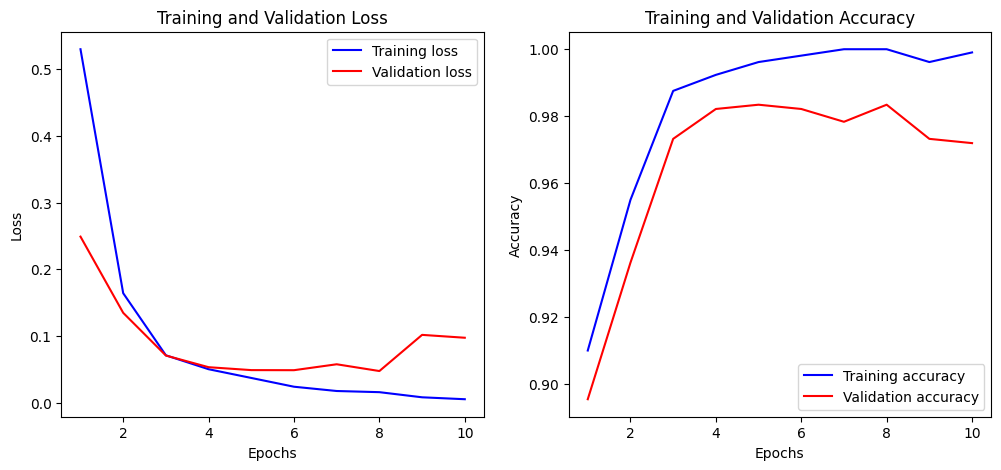

In [5]:
import torch
device=torch.device('cuda')

train_set=GlassesDataset('dataset/train',transform)
val_set=GlassesDataset('dataset/val',transform)
train_loader = DataLoader(train_set, batch_size=6, shuffle=True)
val_loader = DataLoader(val_set, batch_size=6, shuffle=False)


model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 訓練模型並記錄損失和準確率
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
the_best=0.

def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    return correct / total

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # 計算訓練和驗證準確率和損失
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = calculate_accuracy(train_loader, model)
    train_accuracies.append(train_accuracy)

    val_loss = 0.0
    model.eval()
    for data in val_loader:
        inputs, labels = data
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = calculate_accuracy(val_loader, model)
    val_accuracies.append(val_accuracy)

    
    if val_accuracy>the_best:
        the_best=val_accuracy
        torch.save(model.state_dict(),'the_best.ckp')
    
    print(f'Epoch {epoch + 1}/{num_epochs} - '
          f'Train loss: {train_loss:.4f}, Train acc: {train_accuracy:.4f} - '
          f'Val loss: {val_loss:.4f}, Val acc: {val_accuracy:.4f}')

# 繪製損失和準確率曲線圖
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [6]:
with open("glasses_class.txt", "r") as f:
    class_names = [s.strip() for s in f.readlines()]

In [7]:
import skimage.io
import skimage.transform
from skimage import color
def transform_img_fast(path):
    img = skimage.io.imread(path)
    if len(img.shape) != 3:
        img = skimage.color.gray2rgb(img)
    if img.shape[2] == 4:
        img = color.rgba2rgb(img)
    short_egde = min(img.shape[:2])
    yy = int((img.shape[0] - short_egde) / 2)
    xx = int((img.shape[1] - short_egde) / 2)
    crop_img = img[yy: yy + short_egde, xx: xx + short_egde]
    return (skimage.transform.resize(crop_img, (299, 299)) - 0.5) * 2
def transform_img_fn_fast(paths):
    out = []
    for i, path in enumerate(paths):
        if i % 100 == 0:
            print(i)
        out.append(transform_img_fast(path))
    return np.array(out)
#     return np.array([transform_img_fast(path) for path in paths])

In [68]:
#images = transform_img_fn_fast(['dog.jpg'])
images = transform_img_fn_fast(['dataset/test/pos/27368.jpg'])
print(images.shape)

0
(1, 299, 299, 3)


In [69]:
model=SimpleCNN().to(device)
model.load_state_dict(torch.load('the_best.ckp'))
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=43808, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (relu): ReLU()
)

In [70]:
def predict(images):
    images = images.transpose((0, 3, 1, 2))
    input_tensor = torch.FloatTensor(images)
    if torch.cuda.is_available():
        input_tensor = input_tensor.to(device)
    with torch.no_grad():
        output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    return probabilities.cpu().numpy()

In [71]:
import copy
from skimage.segmentation import quickshift, mark_boundaries, slic, felzenszwalb
def ShowImageNoAxis(image, boundaries=None, save=None):
    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    if boundaries is not None:
        ax.imshow(mark_boundaries(image / 2 + 0.5, boundaries))
    else:
        ax.imshow(image / 2 + .5)
    if save is not None:
        plt.savefig(save)
    plt.show()


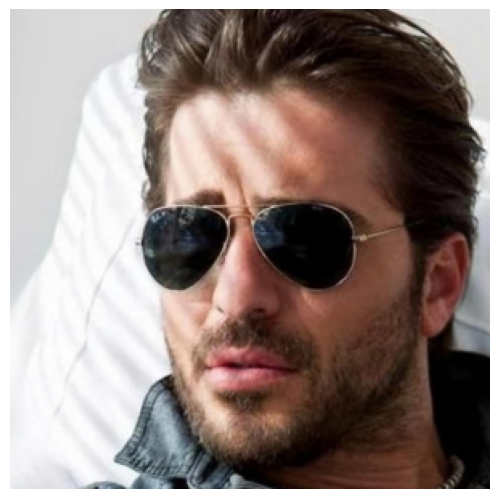

In [72]:
ShowImageNoAxis(images[0])

In [73]:
probs = predict(images)
idxs = np.argsort(-probs[0])
list(zip(probs[0][idxs[:2]], np.array(class_names)[idxs[:2]]))

[(1.0, 'pos'), (9.52034e-09, 'neg')]

In [74]:
import anchor
import anchor.anchor_image

In [75]:
import anchor
#/home/marcotcr/datasets/openimages/train contains a lot of arbitrary images - in this case, from openimages
explainer = anchor.anchor_image.AnchorImage('dataset/val/neg',
                               transform_img_fn=transform_img_fn_fast, n=5000)


0
100
200
300


In [76]:
segments, exp = explainer.explain_instance(images[0], predict, threshold=0.95, batch_size=50,
                                            tau=0.20, verbose=True, min_shared_samples=200, beam_size=2)

True pred 0
Best: 28 (mean:0.6000000000, n: 5, lb:0.0000) Worst: 48 (mean:0.1111, n: 9, ub:1.0000) B = 1.00
Best: 8 (mean:0.6000000000, n: 5, lb:0.0000) Worst: 1 (mean:0.2000, n: 5, ub:1.0000) B = 1.00
Best: 27 (mean:1.0000000000, n: 10, lb:0.0999) Worst: 38 (mean:0.1000, n: 10, ub:1.0000) B = 0.90
Best: 28 (mean:0.5454545455, n: 55, lb:0.1577) Worst: 7 (mean:0.2000, n: 10, ub:1.0000) B = 0.84
Best: 28 (mean:0.5523809524, n: 105, lb:0.2695) Worst: 36 (mean:0.1667, n: 12, ub:1.0000) B = 0.73
Best: 28 (mean:0.5548387097, n: 155, lb:0.3205) Worst: 44 (mean:0.2000, n: 10, ub:1.0000) B = 0.68
Best: 52 (mean:0.5454545455, n: 11, lb:0.0000) Worst: 9 (mean:0.2000, n: 10, ub:1.0000) B = 1.00
Best: 32 (mean:0.5384615385, n: 13, lb:0.0000) Worst: 45 (mean:0.2222, n: 9, ub:1.0000) B = 1.00
Best: 41 (mean:0.5384615385, n: 13, lb:0.0000) Worst: 56 (mean:0.2222, n: 9, ub:1.0000) B = 1.00
Best: 28 (mean:0.5365853659, n: 205, lb:0.3293) Worst: 23 (mean:0.2222, n: 9, ub:1.0000) B = 0.67
Best: 28 (mean:0

In [77]:
exp

[(27, '', 0.9, [], 0), (24, '', 0.9854014598540146, [], 0)]

Anchor for prediction  pos confidence 0.9854014598540146


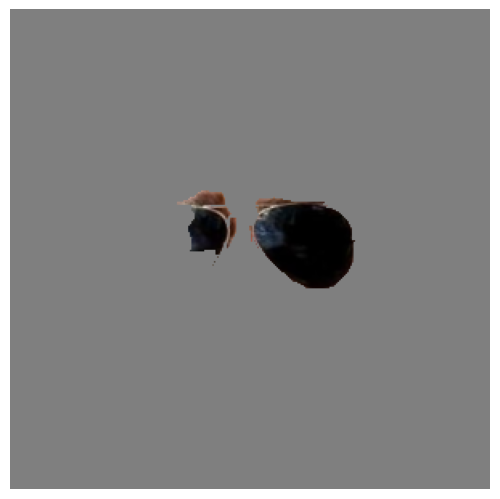

Counter Examples:


In [78]:
def show_exp(segments, exp, image, explainer):
    mask = np.ones(segments.shape).astype(bool)
    temp = copy.deepcopy(image)
    temp_img = copy.deepcopy(temp)
#     temp.img = temp.fudged_image.copy()
    temp[:] = 0
    # for x in exp_greedy[:3]:
    #     x = (x, x)
    for x in exp:
        temp[segments == x[0]] = temp_img[segments==x[0]]
    # temp.img[mask] = np.random.random(mask.nonzero()[0].shape[0] * 3).reshape(mask.nonzero()[0].shape[0], 3)
    print ('Anchor for prediction ', class_names[predict(np.expand_dims(image, 0))[0].argmax()], 'confidence', exp[-1][2])
    ShowImageNoAxis(temp)
    print('Counter Examples:')
    for e in exp[-1][3]:
        data = e[:-1]
        temp = explainer.dummys[e[-1]].copy()
        for x in data.nonzero()[0]:
            temp[segments == x] = image[segments == x]
        ShowImageNoAxis(temp)
        print('Prediction = ', names[predict_fn(np.expand_dims(temp, 0))[0].argmax()])
show_exp(segments, exp, images[0], explainer)

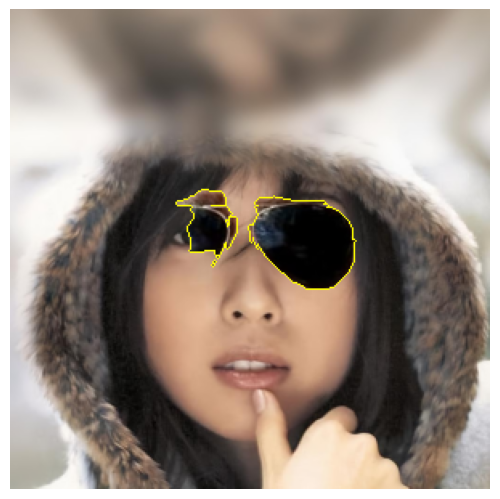

pos 1.0


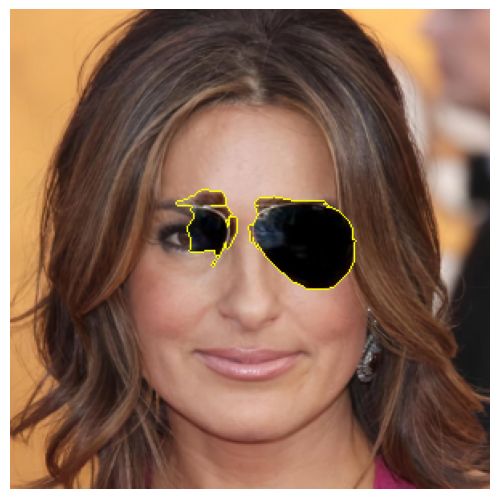

pos 0.99999976


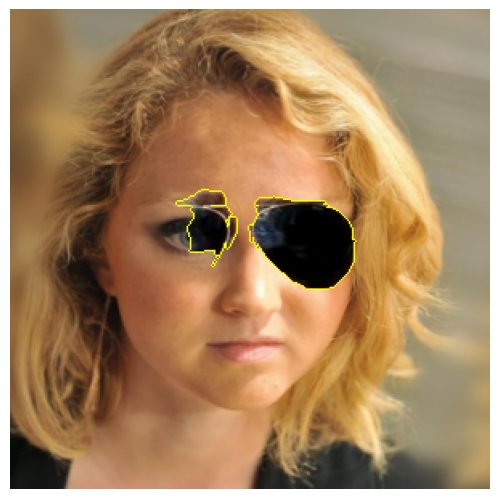

pos 1.0


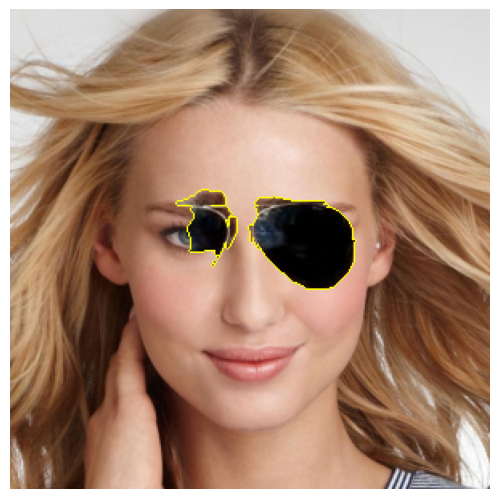

pos 1.0


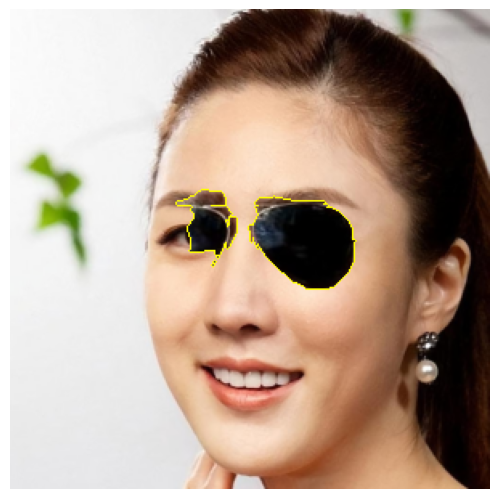

pos 1.0


In [79]:
N = 5
chosen = np.random.choice(len(explainer.dummys), N)
imgs = []
masks = []
for c in chosen:
    temp = copy.deepcopy(explainer.dummys[c])
    mask = np.zeros(segments.shape).astype(bool)
    for f in exp:
        f = f[0]
        mask[segments == f] = 1
    temp[mask] = images[0][mask].copy()
    imgs.append(temp)
    masks.append(mask)
preds = predict(np.array(imgs))
for i, p in zip(imgs, preds):
#     if p.max() < 0.9:
#         continue
    ShowImageNoAxis(i, mask, '/tmp/nickz.png')
    print(class_names[p.argmax()], p.max())